# Conditional VAE Fashion MNIST

Note: This notebook is designed to run with GPU runtime.

Import modules and set random seeds.

In [ ]:
import os, random
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import colormaps
import tensorflow as tf
from tensorflow.keras import layers, models, losses
from tensorflow.keras.datasets import fashion_mnist

random.seed(20230629)
np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the Fashion MNIST dataset and store into NumPy arrays.

In [ ]:
(train_images, train_labels), _ = fashion_mnist.load_data()
train_images = np.pad(train_images, ((0, 0), (2, 2), (2, 2)))
train_images = train_images.reshape(
                    (len(train_images), 32*32)).astype('float32') / 255
train_labels = tf.keras.utils.to_categorical(train_labels, 10)

Create labeled images to train the Conditional Variational AutoEncoder.

In [ ]:
labeled_images = np.hstack([train_images, train_labels])

Define the encoder with convolutional filters.

In [ ]:
encoder = models.Sequential(name='encoder')
encoder.add(layers.Input(shape=(32*32,), name='encoder_input'))
encoder.add(layers.Reshape((32, 32, 1), name='reshape'))
encoder.add(layers.Conv2D(32, (3, 3), strides=2, padding='same',
                activation='relu', name='conv_filter1')) # (16, 16, 32)
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same',
                activation='relu', name='conv_filter2')) # (8, 8, 64)
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same',
                activation='relu', name='conv_filter3')) # (4, 4, 128)
encoder.add(layers.Flatten(name='flatten'))
encoder.add(layers.Dense(4, name='mean_and_log_var'))

encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_filter1 (Conv2D)                │ (None, 16, 16, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_filter2 (Conv2D)                │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_filter3 (Conv2D)                │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mean_and_log_var (Dense)             │ (None, 4)                   │           8,196 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

Define the sampler from the normal distribution.

In [ ]:
def get_samples(x): # x: encoder output
    num_examples = tf.shape(x)[0]
    means, log_vars = x[:, 0:2], x[:, 2:4]
    std_samples = tf.random.normal(shape=(num_examples, 2))
    samples = means + tf.exp(0.5 * log_vars) * std_samples
    return samples

sampler = models.Sequential(name='sampler')
sampler.add(layers.Input(shape=(4,), name='sampler_input'))
sampler.add(layers.Lambda(get_samples, name='sampled_embedding'))

sampler.summary()

Model: "sampler"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sampled_embedding (Lambda)           │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Define the decoder with transoposed convolutional filters conditioned with the label data.

In [ ]:
decoder = models.Sequential(name='conditional_decoder')
decoder.add(layers.Input(shape=(12,), name='decoder_input'))
decoder.add(layers.Dense(4 * 4 * 128, name='expand'))
decoder.add(layers.Reshape((4, 4, 128), name='reshape'))
decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same',
                activation='relu', name='conv_transpose1')) # (8, 8, 64)
decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same',
                activation='relu', name='conv_transpose2')) # (16, 16, 32)
decoder.add(layers.Conv2DTranspose(1, (3, 3), strides=2, padding='same',
                activation='sigmoid', name='conv_transpose3')) # (32, 32, 1)
decoder.add(layers.Flatten(name='flatten'))

decoder.summary()

Model: "conditional_decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ expand (Dense)                       │ (None, 2048)                │          26,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_transpose1 (Conv2DTranspose)    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_transpose2 (Conv2DTranspose)    │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_transpose3 (Conv2DTranspose)    │ (None, 32, 32, 1)           │             289 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,169 (465.50 KB)

 Trainable params: 119,169 (465.50 KB)

 Non-trainable params: 0 (0.00 B)

Define the conditional Variational AutoEncoder.


In [ ]:
model_inputs = tf.keras.Input(shape=(32*32+10,), name='model_inputs')
input_images, input_labels = model_inputs[:, 0:1024], model_inputs[:, 1024:1034]
decoder_inputs = layers.Concatenate(name='decoder_inputs')(
    [sampler(encoder(input_images)), input_labels])
model_outputs = layers.Concatenate(name='prediction_with_mean_log_var')(
    [encoder(input_images), decoder(decoder_inputs)])

model = models.Model(inputs=model_inputs, outputs=model_outputs,
                     name='conditional_VAE')
model.summary()

Model: "conditional_VAE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ model_inputs (InputLayer) │ (None, 1034)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 1024)           │              0 │ model_inputs[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder (Sequential)      │ (None, 4)              │        100,868 │ get_item[0][0],        │
│                           │                        │                │ get_item[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampler (Sequential)      │ (None, 2)              │              0 │ encoder[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 10)             │              0 │ model_inputs[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, 12)             │              0 │ sampler[0][0],         │
│ (Concatenate)             │                        │                │ get_item_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conditional_decoder       │ (None, 1024)           │        119,169 │ decoder_inputs[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ prediction_with_mean_log… │ (None, 1028)           │              0 │ encoder[1][0],         │
│ (Concatenate)             │                        │                │ conditional_decoder[0… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 220,037 (859.52 KB)

 Trainable params: 220,037 (859.52 KB)

 Non-trainable params: 0 (0.00 B)

Define the custom loss funtion using the KL divergence.



In [ ]:
def custom_loss(y_true, y_pred):
    mean, log_var, pred = y_pred[:, 0:2], y_pred[:, 2:4], y_pred[:, 4:1028]
    reconstruction_loss = losses.mse(pred, y_true)
    kl_loss = tf.reduce_mean(tf.reduce_sum(
        -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var)), axis=1))
    loss = reconstruction_loss + 0.001 * kl_loss
    return loss

Compile the model using the Adam optimizer and the custom loss function.

In [ ]:
model.compile(optimizer='adam', loss=custom_loss)

Train the model and show the result.

In [ ]:
%%time
history = model.fit(labeled_images, train_images,
                    batch_size=128, epochs=50)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.0752
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0271
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0258
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0253
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0250
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0248
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0247
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0246
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0244
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0244
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0243
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0242
Epoch 13/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0242
Epoch 14/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0241
Epoch 15/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - 

Show the embeddings of training data.

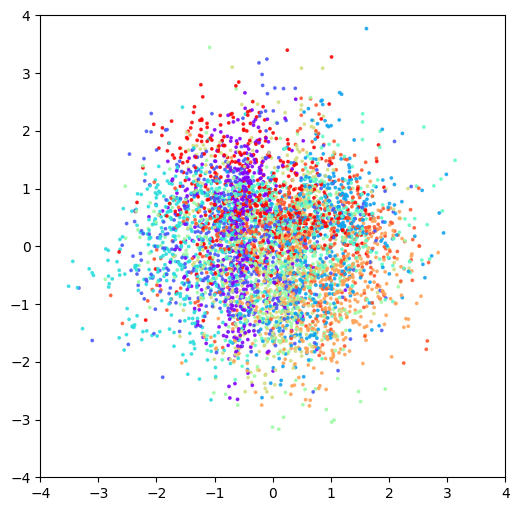

In [ ]:
embeddings = encoder.predict(train_images[:5000], verbose=0)
example_labels = np.argmax(train_labels[:5000], axis=1)

fig = plt.figure(figsize=(6, 6))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xlim((-4, 4))
subplot.set_ylim((-4, 4))
_ = subplot.scatter(embeddings[:, 0], embeddings[:, 1],
                    cmap='rainbow', c=example_labels, alpha=0.8, s=3)

Show the embeddings of training data over the entire embedding space through a variable conversion with the sigmoid function.

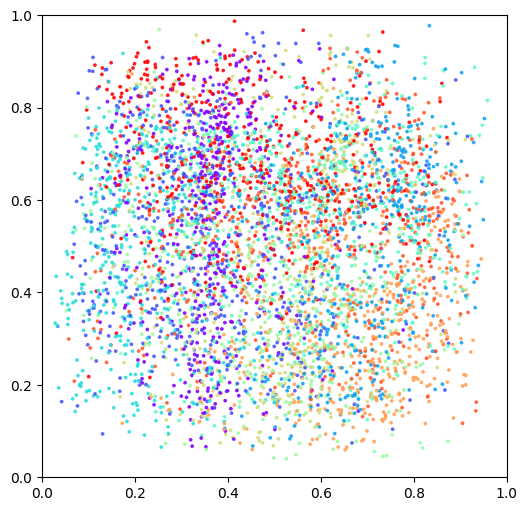

In [ ]:
fig = plt.figure(figsize=(6, 6))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xlim((0, 1))
subplot.set_ylim((0, 1))
sigmoid = lambda x: 1/(1 + np.exp(-x))
_ = subplot.scatter(sigmoid(embeddings[:, 0]), sigmoid(embeddings[:, 1]),
                    cmap='rainbow', c=example_labels, alpha=0.8, s=3)

Show reconstruction images over the entire embedding space for each label.

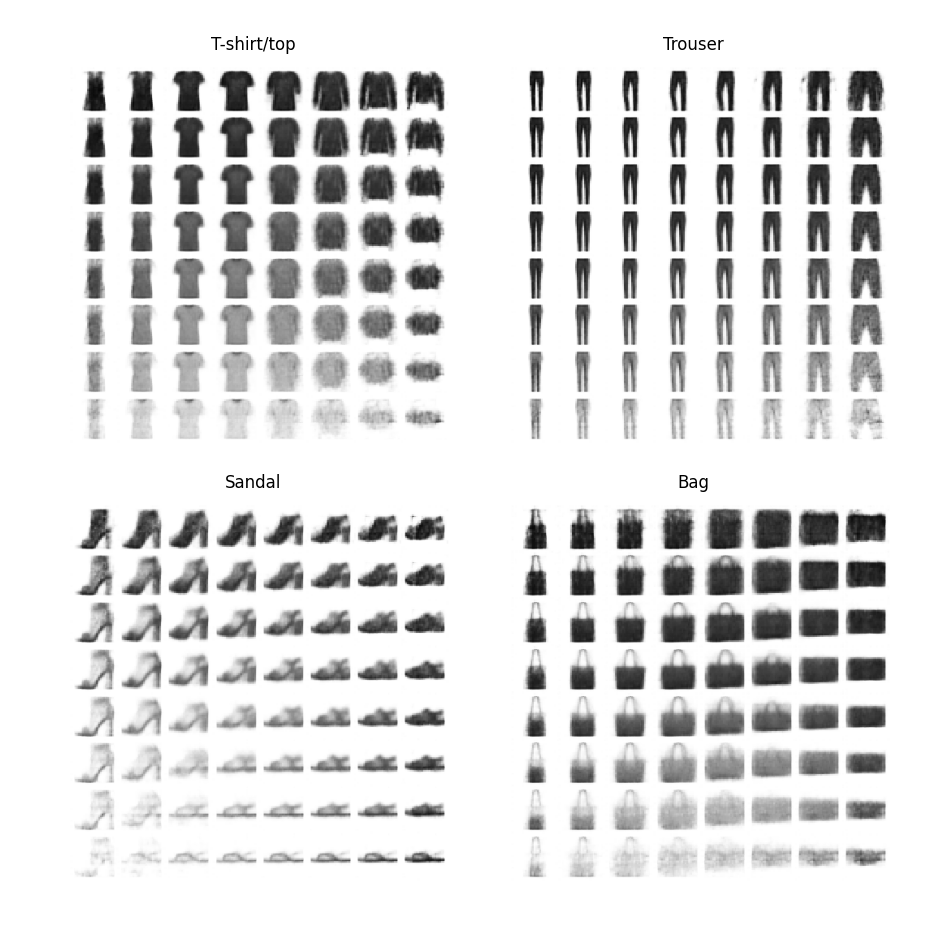

In [ ]:
def add_grid_images(fig, label):
    x = np.linspace(0.1, 0.9, 8)
    y = np.linspace(0.9, 0.1, 8)
    xv, yv = np.meshgrid(x, y)
    logit = lambda x: np.log(x)-np.log(1-x)
    grid = np.array([*zip(logit(xv.flatten()), logit(yv.flatten()))])
    grid = np.hstack([grid, np.tile(label, len(grid)).reshape(len(grid), 10)])
    reconstructions = decoder.predict(grid, verbose=0)
    fig.subplots_adjust(hspace=0, wspace=0)
    for i in range(8*8):
        subplot = fig.add_subplot(8, 8, i + 1)
        subplot.axis('off')
        subplot.imshow(reconstructions[i].reshape((32, 32)), interpolation='none',
                       vmin=0, vmax=1, cmap=plt.cm.gray_r)

labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
          'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig = plt.figure(figsize=(6, 6))
for c, item in enumerate([0, 1, 5, 8]):
    label = [0] * 10
    label[item] = 1
    add_grid_images(fig, label)
    fig.savefig('tmp_{}.png'.format(c))
    plt.close()

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=-0.1, wspace=-0.1)
for c, item in enumerate([0, 1, 5, 8]):
    subplot = fig.add_subplot(2, 2, c + 1)
    subplot.set_title(labels[item], x=0.5, y=0.9)
    subplot.axis('off')
    img = plt.imread('tmp_{}.png'.format(c))
    subplot.imshow(img)

Show images generated with mixed labels.

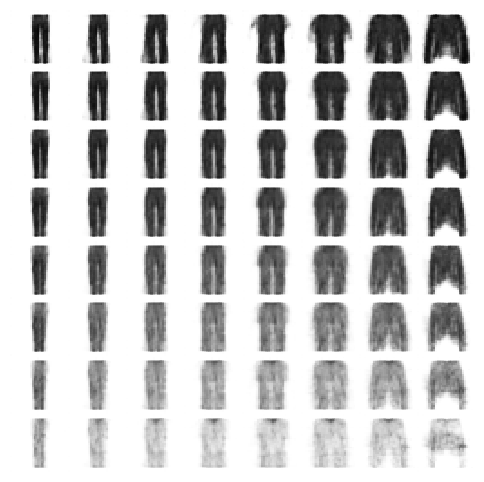

In [ ]:
fig = plt.figure(figsize=(6, 6))
label = [0] * 10
label[1], label[6] = 0.5, 0.5 # Trouser + Shirt
add_grid_images(fig, label)

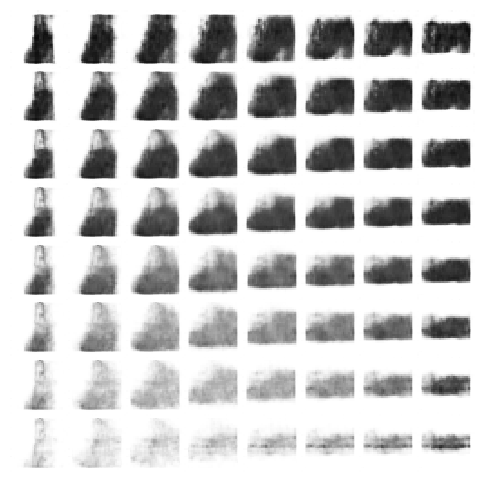

In [ ]:
fig = plt.figure(figsize=(6, 6))
label = [0] * 10
label[8], label[9] = 0.6, 0.4 # Bag + Ankle Boot
add_grid_images(fig, label)